# TensorFlow

In [1]:
import tensorflow as tf
import numpy as np

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
tf.__version__

'1.11.0'

In [4]:
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

In [5]:
sess = tf.Session()

In [6]:
sess.run(x.initializer)  # initialize a variable
sess.run(y.initializer)
result = sess.run(f)
print(result)

42


In [7]:
sess.close()

The same as above:

In [15]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()

Or that way:

In [16]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()  # initialize all variables
    result = f.eval()

In case of working with Jupyter it is possible to create 'standard' session by using ``InteractiveSession``. But at the end we need to close it manually.

In [10]:
sess = tf.InteractiveSession()

In [11]:
init.run()
result = f.eval()
print(result)

42


In [12]:
sess.close()

### Graph management

In [13]:
x1 = tf.Variable(1)

In [14]:
x1.graph is tf.get_default_graph()

True

Creating another graph instance:

In [15]:
graph = tf.Graph()

with graph.as_default():
    x2 = tf.Variable(2)

In [16]:
x2.graph is graph

True

In [17]:
x2.graph is tf.get_default_graph()

False

**Note:** Use ``tf.reset_default_graph()`` to clean the graph (e.g. in case of relaunching some cells multiple times)

### Node life cycle:

In [18]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())
    print(z.eval())

10
15


Code above estimates w and x twice.

And the code below will estimate them once.

In [19]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)
    print(z_val)

10
15


## Linear Regression
### Using the Normal Equation

$\hat{\theta} = \left(\mathbf{X}^T\cdot\mathbf{X}\right)^{-1}\cdot\mathbf{X}^T\cdot\mathbf{y}$

In [7]:
import numpy as np
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()

In [8]:
theta_value

array([[-3.7383255e+01],
       [ 4.3574786e-01],
       [ 9.3480907e-03],
       [-1.0648697e-01],
       [ 6.4317447e-01],
       [-4.2286665e-06],
       [-3.7746700e-03],
       [-4.2583770e-01],
       [-4.3952349e-01]], dtype=float32)

In [9]:
housing.data.shape

(20640, 8)

In [10]:
len(theta_value)

9

## Batch Gradient Descent (by hand)

In [11]:
from sklearn.preprocessing import StandardScaler

Scale the data for gradient descent:

In [12]:
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [13]:
scaled_housing_data_plus_bias.mean()

0.11111111111111005

$MSE(\theta) = \dfrac{1}{m}\sum_{i=1}^{m}(\theta^T\cdot\mathbf{x}^{(i)} - y^{(i)})^2$

$\dfrac{\partial}{\partial{\theta_j}}MSE(\theta) = \dfrac{2}{m}\sum_{i=1}^{m}(\theta^T\cdot\mathbf{x}^{(i)} - y^{(i)})x_j^{(i)}$

$\nabla_{\theta}MSE(\theta) = \left\lgroup\begin{array}{c}
\dfrac{\partial}{\partial{\theta_0}}MSE(\theta)\\
\dfrac{\partial}{\partial{\theta_1}}MSE(\theta)\\
\vdots\\
\dfrac{\partial}{\partial{\theta_n}}MSE(\theta)\\
\end{array}\right\rgroup = \dfrac{2}{m}\mathbf{X}^T\cdot(\mathbf{X}\cdot\theta-\mathbf{y})$

In [56]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    best_theta = theta.eval()

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.56670463
Epoch 300 MSE = 0.5555716
Epoch 400 MSE = 0.5488116
Epoch 500 MSE = 0.54363626
Epoch 600 MSE = 0.53962916
Epoch 700 MSE = 0.53650916
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.532147


In [57]:
best_theta

array([[ 2.0685523 ],
       [ 0.8874027 ],
       [ 0.14401656],
       [-0.3477088 ],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.66145295],
       [-0.63752794]], dtype=float32)

### Autodiff

In [58]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = tf.gradients(mse, [theta])[0]                                    # <-- autodiff
training_op = tf.assign(theta, theta - learning_rate * gradients)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    best_theta = theta.eval()

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.56670463
Epoch 300 MSE = 0.55557156
Epoch 400 MSE = 0.5488117
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.53962916
Epoch 700 MSE = 0.53650916
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.53214705


In [59]:
best_theta

array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.14401655],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269557],
       [-0.66145295],
       [-0.63752794]], dtype=float32)

### Optimizer

In [60]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)    # <-- optimizer
training_op = optimizer.minimize(mse)                                         # <-- minimizing mse
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    best_theta = theta.eval()

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.56670463
Epoch 300 MSE = 0.55557156
Epoch 400 MSE = 0.5488117
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.53962916
Epoch 700 MSE = 0.53650916
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.53214705


In [61]:
best_theta

array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.14401655],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269557],
       [-0.66145295],
       [-0.63752794]], dtype=float32)

## Mini-Batch Gradient Descent

In [31]:
A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})
print("B_val_1:", B_val_1)
print("B_val_2:\n", B_val_2)

B_val_1: [[6. 7. 8.]]
B_val_2:
 [[ 9. 10. 11.]
 [12. 13. 14.]]


In [64]:
reset_graph()

n_epochs = 10
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

batch_size = 100
n_batches = int(np.ceil(m / batch_size))

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)    # <-- optimizer
training_op = optimizer.minimize(mse)                                         # <-- minimizing mse
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    best_theta = theta.eval()

In [65]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255149],
       [-0.31211883],
       [ 0.38510382],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

## Saving and Restoring Models

### Saving

In [66]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver()                 # <-- Saver

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
            save_path = saver.save(sess, "../data/tmp/my_model.ckpt")
        sess.run(training_op)
    best_theta = theta.eval()
    save_path = saver.save(sess, "../data/tmp/my_model_final.ckpt")

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.56670463
Epoch 300 MSE = 0.55557156
Epoch 400 MSE = 0.5488117
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.53962916
Epoch 700 MSE = 0.53650916
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.53214705


In [67]:
best_theta

array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.14401655],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269557],
       [-0.66145295],
       [-0.63752794]], dtype=float32)

### Restore

In [68]:
with tf.Session() as sess:
    saver.restore(sess, "../data/tmp/my_model_final.ckpt")   # <-- in plcae of sess.run(init)
    best_theta_restored = theta.eval()

INFO:tensorflow:Restoring parameters from ../data/tmp/my_model_final.ckpt


In [69]:
np.allclose(best_theta, best_theta_restored)

True

Or we even can restore whole graph (with all variables - it means we don't have to run some code to declare that variables)

In [71]:
reset_graph()  # <-- reset grapgh - all initialized variables will be lost

saver = tf.train.import_meta_graph("../data/tmp/my_model_final.ckpt.meta")
theta = tf.get_default_graph().get_tensor_by_name("theta:0")

with tf.Session() as sess:
    saver.restore(sess, "../data/tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval()

INFO:tensorflow:Restoring parameters from ../data/tmp/my_model_final.ckpt


In [72]:
np.allclose(best_theta, best_theta_restored)

True

## Visualizing the graph and learning curves by using TensorBoard

In [79]:
from datetime import datetime

In [94]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "../tf_logs"
logdir = "{}/run-{}".format(root_logdir, now)

n_epochs = 10
learning_rate = 0.01
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="MSE")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    best_theta = theta.eval()

In [95]:
file_writer.close()

In [96]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255149],
       [-0.31211883],
       [ 0.38510382],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

## Name scopes

In [97]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "../tf_logs"
logdir = "{}/run-{}".format(root_logdir, now)

n_epochs = 10
learning_rate = 0.01
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

########################
# Defining a namespace #
########################
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="MSE")

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    best_theta = theta.eval()

In [98]:
file_writer.close()

In [99]:
print(error.op.name)

loss/sub


In [100]:
print(mse.op.name)

loss/MSE


## Modularity

Rectified linear unit (ReLU):

$h_{\mathbf{w},\:b}(\mathbf{X})=\max(\mathbf{X}\cdot\mathbf{w}+b, 0)$

In [102]:
reset_graph()

In [103]:
def relu(X):
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name="weights")
    b = tf.Variable(0.0, name="bias")
    z = tf.add(tf.matmul(X, w), b, name="z")
    return tf.maximum(z, 0., name="relu")

n_features = 3
X = tf.placeholder(dtype=tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [104]:
file_writer = tf.summary.FileWriter("../tf_logs/relu", tf.get_default_graph())

In [105]:
file_writer.close()

Or even better way with name scope using:

In [106]:
reset_graph()

def relu(X):
    with tf.name_scope("relu") as scope:
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, 0., name="relu")

n_features = 3
X = tf.placeholder(dtype=tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("../tf_logs/relu_1", tf.get_default_graph())
file_writer.close()

### Sharing Variables

In [114]:
reset_graph()

def relu(X, threshold):
    with tf.name_scope("relu") as scope:
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="relu")

n_features = 3
threshold = tf.Variable(0.0, name="threshold")
X = tf.placeholder(dtype=tf.float32, shape=(None, n_features), name="X")
relus = [relu(X, threshold) for i in range(5)]   # Use threshold for each relu node
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("../tf_logs/relu_2", tf.get_default_graph())
file_writer.close()

Code above isn't very useful because we must pass 'threshold' value to the function every time we call it.

That's why we can use ``variable_scope``

In [115]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("threshold")
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="relu")

with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))

X = tf.placeholder(dtype=tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("../tf_logs/relu_3", tf.get_default_graph())
file_writer.close()

And the last improvement - we can place the code for our 'threshold' variable into relu function:

In [117]:
reset_graph()

def relu(X):
    threshold = tf.get_variable("threshold", shape=(), 
                                initializer=tf.constant_initializer(0.0))   # This code will create a variable 
                                                                            # if it isn't exist; or will reuse it 
                                                                            # in other cases
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name="weights")
    b = tf.Variable(0.0, name="bias")
    z = tf.add(tf.matmul(X, w), b, name="z")
    return tf.maximum(z, threshold, name="relu")

X = tf.placeholder(dtype=tf.float32, shape=(None, n_features), name="X")
relus = []
for relu_index in range(5):
    with tf.variable_scope("relu", reuse=(relu_index >= 1)) as scope:
        relus.append(relu(X))
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("../tf_logs/relu_4", tf.get_default_graph())
file_writer.close()

# Exercise
## Logistic Regression with Mini-Batch Gradient Descent

In [3]:
import matplotlib.pyplot as plt

In [4]:
reset_graph()

In [5]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

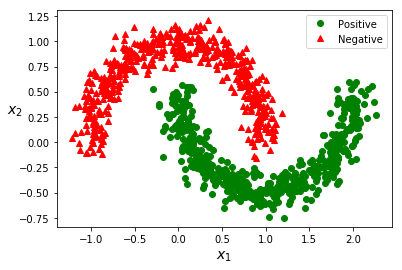

In [6]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], "go", label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], "r^", label="Negative")
plt.xlabel(r"$x_1$", fontsize=14)
plt.ylabel(r"$x_2$", fontsize=14, rotation=0)
plt.legend(loc="upper right");

In [7]:
X_moons_with_bias = np.c_[np.ones(m), X_moons]
X_moons_with_bias.shape

(1000, 3)

In [8]:
y_moons.shape

(1000,)

In [9]:
y_moons_vector = y_moons.reshape(-1, 1)
y_moons_vector.shape

(1000, 1)

In [10]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
y_train = y_moons_vector[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_test = y_moons_vector[-test_size:]

print("X_train:", X_train.shape, "y_train:", y_train.shape, "X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (800, 3) y_train: (800, 1) X_test: (200, 3) y_test: (200, 1)


In [11]:
def random_batch(X_train, y_train, batch_size=5):
    indices = np.random.randint(len(X_train), size=batch_size)
    X_batch = X_train[indices]
    y_batch = y_train[indices]
    return X_batch, y_batch

In [12]:
X_batch, y_batch = random_batch(X_train, y_train)
print(X_batch)
print(y_batch)

[[ 1.          1.93189866  0.13158788]
 [ 1.          1.07172763  0.13482039]
 [ 1.         -1.01148674 -0.04686381]
 [ 1.          0.02201868  0.19079139]
 [ 1.         -0.98941204  0.02473116]]
[[1]
 [0]
 [0]
 [1]
 [0]]


In [13]:
n_inputs = 2 # since X dataset has two features: x_1 and x_2

$\hat{p}=h_\theta(\mathbf{x})=\sigma(\theta^T\cdot\mathbf{x})$

$\sigma(t) = \dfrac{1}{1 + \text{exp}(-t)}$

$\hat{y} = \begin{cases}
0,\:\text{if}\:\hat{p}<0.5\\
1,\:\text{if}\:\hat{p}\geq0.5\\
\end{cases}$

Cost function for one sample:

$c(\theta)=\left\{\begin{array}{lr}
-log(\hat{p}), & \text{if } y=1,\\
-log(1-\hat{p}), & \text{if } y=0.\\
\end{array}\right.$

Cost function (also known as _**log loss**_) for Logistic Regression:

$J(\theta) = -\dfrac{1}{m}\sum_{i=1}^m[y^{(i)}log(\hat{p}^{(i)})+(1-y^{(i)})log(1-\hat{p}^{(i)})]$

$\dfrac{\partial}{\partial\theta_j}J(\theta)=\dfrac{1}{m}\sum_{i=1}^m
(\sigma(\theta^T\cdot\mathbf{x}^{(i)})-y^{(i)})x_j^{(i)})$

In [14]:
X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")
# y_proba = 1 / 1 + tf.exp(-logits)

In [15]:
y_proba = tf.sigmoid(logits)

In [16]:
epsilon = 1E-7
# loss = - tf.reduce_mean(y * tf.log(y_proba) + (1 - y) * tf.log(1 - y_proba))

The same with TensorFlow's ``log_loss`` function:

In [17]:
loss = tf.losses.log_loss(y, y_proba)  # uses epsilon = 1e-7 by default

In [18]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [19]:
init = tf.global_variables_initializer()

Our graph nodes are ready - we can start a learning session:

In [20]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch: {}\tLoss: {}".format(epoch, loss_val))
    y_proba_val = y_proba.eval({X: X_test})

Epoch: 0	Loss: 0.7926272749900818
Epoch: 100	Loss: 0.343455970287323
Epoch: 200	Loss: 0.3075346350669861
Epoch: 300	Loss: 0.2928895950317383
Epoch: 400	Loss: 0.2853357791900635
Epoch: 500	Loss: 0.28047633171081543
Epoch: 600	Loss: 0.2780900001525879
Epoch: 700	Loss: 0.27615517377853394
Epoch: 800	Loss: 0.2755153179168701
Epoch: 900	Loss: 0.27491727471351624


In [21]:
y_proba_val[:5]

array([[0.54899573],
       [0.70736086],
       [0.5190373 ],
       [0.9911169 ],
       [0.5086759 ]], dtype=float32)

In [26]:
y_pred = (y_proba_val >= 0.5).astype(int)
y_pred[:3]

array([[1],
       [1],
       [1]])

Save the graph (but not the model!):

In [22]:
file_writer = tf.summary.FileWriter("../tf_logs/logReg", tf.get_default_graph())
file_writer.close()

In [23]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [29]:
print("Recall score:", recall_score(y_test, y_pred))
print("Precision score:", precision_score(y_test, y_pred))

Recall score: 0.8888888888888888
Precision score: 0.8627450980392157


In [31]:
X_test.shape

(200, 3)

In [32]:
y_pred.shape

(200, 1)

Let's plot predictions:

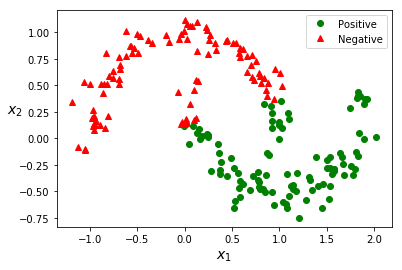

In [34]:
plt.plot(X_test[y_pred.ravel() == 1, 1], X_test[y_pred.ravel() == 1, 2], "go", label="Positive")
plt.plot(X_test[y_pred.ravel() == 0, 1], X_test[y_pred.ravel() == 0, 2], "r^", label="Negative")
plt.xlabel(r"$x_1$", fontsize=14)
plt.ylabel(r"$x_2$", fontsize=14, rotation=0)
plt.legend(loc="upper right");

Now we're going to improve our model:

Add some new features.

In [121]:
X_train_enhanced = np.c_[X_train, np.square(X_train[:, 1]), 
                         np.square(X_train[:, 2]), 
                         X_train[:, 1] ** 3, 
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test, np.square(X_test[:, 1]), 
                        np.square(X_test[:, 2]), 
                        X_test[:, 1] ** 3, 
                        X_test[:, 2] ** 3]
print("X_train_enhanced.shape: ", X_train_enhanced.shape, "X_test_enhanced.shape: ", X_test_enhanced.shape)

X_train_enhanced.shape:  (800, 7) X_test_enhanced.shape:  (200, 7)


Create a function for nodes generation:

In [166]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_with_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_with_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar("loss", loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

In [128]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "../tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    logdir = "{}/{}".format(root_logdir, name)
    return logdir

Create a new graph:

In [265]:
reset_graph()

In [267]:
n_inputs = 2 + 4  # number of features
logdir = log_dir("logreg")

X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [137]:
import os

Train the model:

In [268]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "../data/tmp/logreg_model/my_logreg_model.ckpt"
checkpoint_path_epoch = "../data/tmp/logreg_model/my_logreg_model.ckpt.epoch"
final_model_path = "../data/tmp/logreg_model/my_final_logreg_model"

with tf.Session() as sess:
    if os.path.exists(checkpoint_path_epoch):
        with open(checkpoint_path_epoch, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch: {}\tLoss: {}".format(epoch, loss_val))
            save_path = saver.save(sess, checkpoint_path)
            with open(checkpoint_path_epoch, "wb") as f:
                f.write(b"%d" % (epoch + 1))
    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced})    
    os.remove(checkpoint_path_epoch)

Epoch: 0	Loss: 0.629984974861145
Epoch: 500	Loss: 0.1612236350774765
Epoch: 1000	Loss: 0.1190321072936058
Epoch: 1500	Loss: 0.09732921421527863
Epoch: 2000	Loss: 0.08369796723127365
Epoch: 2500	Loss: 0.07437583804130554
Epoch: 3000	Loss: 0.06750216335058212
Epoch: 3500	Loss: 0.062206897884607315
Epoch: 4000	Loss: 0.058026790618896484
Epoch: 4500	Loss: 0.054562970995903015
Epoch: 5000	Loss: 0.05170828849077225
Epoch: 5500	Loss: 0.04923773929476738
Epoch: 6000	Loss: 0.04716729000210762
Epoch: 6500	Loss: 0.04537663608789444
Epoch: 7000	Loss: 0.043818749487400055
Epoch: 7500	Loss: 0.04237421602010727
Epoch: 8000	Loss: 0.04108916223049164
Epoch: 8500	Loss: 0.039970919489860535
Epoch: 9000	Loss: 0.03892024606466293
Epoch: 9500	Loss: 0.038010746240615845
Epoch: 10000	Loss: 0.03715569153428078


In [210]:
y_pred = (y_proba_val >= 0.5).astype(int).reshape(-1)
y_pred[:5]

array([1, 1, 1, 1, 0])

Plot predictions:

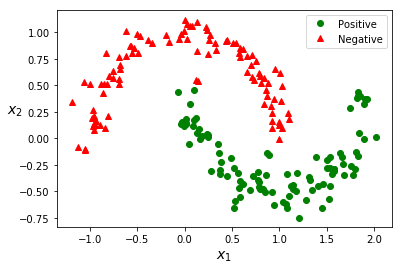

In [211]:
plt.plot(X_test_enhanced[y_pred == 1, 1], X_test_enhanced[y_pred == 1, 2], "go", label="Positive")
plt.plot(X_test_enhanced[y_pred == 0, 1], X_test_enhanced[y_pred == 0, 2], "r^", label="Negative")
plt.xlabel(r"$x_1$", fontsize=14)
plt.ylabel(r"$x_2$", fontsize=14, rotation=0)
plt.legend(loc="upper right");

Let's also plot decision boundary:

In [212]:
def add_features(X):
    X_enhanced = np.c_[X, np.square(X[:, 0]), 
                       np.square(X[:, 1]), 
                       X[:, 0] ** 3, 
                       X[:, 1] ** 3]
    X_enhanced_with_bias = np.c_[np.ones(X.shape[0]), X_enhanced]
    return X_enhanced_with_bias

Create the grid and run y_proba node. But before running we have to reload our model to get "learned" values:

In [262]:
x_1 = np.linspace(-1.5, 2.5, 1000)
x_2 = np.linspace(-0.8, 1.3, 1000)
xx1, xx2 = np.meshgrid(x_1, x_2)
test_X = np.hstack((xx1.reshape(-1, 1), xx2.reshape(-1, 1)))
test_X_enhanced = add_features(test_X)
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)    # reload model
    y_pred_new = y_proba.eval(feed_dict={X: test_X_enhanced})

INFO:tensorflow:Restoring parameters from ../data/tmp/logreg_model/my_logreg_model.ckpt


In [263]:
y_pred_new = y_pred_new.reshape(xx1.shape)

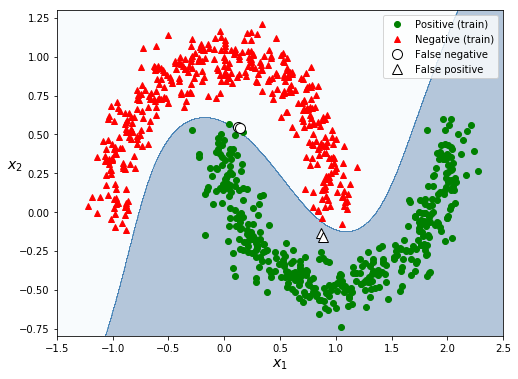

In [286]:
plt.figure(figsize=(8, 6))
plt.contourf(xx1, xx2, (y_pred_new >= 0.5).astype(int), alpha=0.3, cmap=plt.cm.Blues)
plt.plot(X_train[y_train.ravel() == 1, 1], X_train[y_train.ravel() == 1, 2], "go", label="Positive (train)")
plt.plot(X_train[y_train.ravel() == 0, 1], X_train[y_train.ravel() == 0, 2], "r^", label="Negative (train)")
plt.plot(X_test[(y_test.ravel() == 1) & (y_pred == 0), 1], 
         X_test[(y_test.ravel() == 1) & (y_pred == 0), 2], "ko", ms=10, mfc="w", label="False negative")
plt.plot(X_test[(y_test.ravel() == 0) & (y_pred == 1), 1], 
         X_test[(y_test.ravel() == 0) & (y_pred == 1), 2], "k^", ms=10, mfc="w", label="False positive")
plt.xlabel(r"$x_1$", fontsize=14)
plt.ylabel(r"$x_2$", fontsize=14, rotation=0)
plt.legend(loc="upper right");